In [1]:
# ! pip install transformers peft datasets

## Whisper (Web scale pretraining for speech recognition)
 - Fintune the whisper model on specific language datasets
 - taking Hindi as an example
 - can apply LoRA to this as this is a simple transformer under the hood...

In [2]:
# perform the necessary imports

import os
import json
import numpy as np
import torch
from tqdm import tqdm
import wandb

from transformers import AutoModelForSpeechSeq2Seq, AutoTokenizer, AutoFeatureExtractor
from peft import LoraConfig
from datasets import load_dataset, DatasetDict
from datasets import Audio

from transformers import TrainingArguments, Seq2SeqTrainer

from huggingface_hub import login


In [3]:
# load the tokens and secrets
with open('secrets/secrets.json', 'r') as f:
    secrets = json.load(f)

# login with the secrets

login(token=secrets['HF_TOKEN'])
wandb.login(key=secrets['WANDB_TOKEN'])

Token has not been saved to git credential helper. Pass `add_to_git_credential=True` if you want to set the git credential as well.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Token is valid (permission: read).
Your token has been saved to /home/ostrich/.cache/huggingface/token
Login successful


wandb: Currently logged in as: parth-shastri. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/ostrich/.netrc


True

### Load the Model

In [4]:
model_name = 'openai/whisper-small'   # experimenting with the small model

model = AutoModelForSpeechSeq2Seq.from_pretrained(model_name)
# Define the tokenizer and the feature_processor, the language and the task are defined later.
tokenizer = AutoTokenizer.from_pretrained(model_name)
feature_extractor = AutoFeatureExtractor.from_pretrained(model_name)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [5]:
model.generation_config.language = 'hindi'
model.generation_config.task = "transcribe"

model.generation_config.forced_decoder_ids = None

In [6]:
# look at the model architecture
# model

### Load the dataset and prepare the tokenizers

In [7]:
common_voice = DatasetDict()

common_voice['train'] = load_dataset('mozilla-foundation/common_voice_11_0', 'hi', split='train+validation', trust_remote_code=True)
common_voice["test"] = load_dataset(
    "mozilla-foundation/common_voice_11_0", "hi", split="test", trust_remote_code=True
)

In [8]:
common_voice

DatasetDict({
    train: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 6540
    })
    test: Dataset({
        features: ['client_id', 'path', 'audio', 'sentence', 'up_votes', 'down_votes', 'age', 'gender', 'accent', 'locale', 'segment'],
        num_rows: 2894
    })
})

In [9]:
common_voice = common_voice.remove_columns(
    [
        "client_id",
        "accent",
        "age",
        "down_votes",
        "up_votes",
        "gender",
        "locale",
        "path",
        "segment",
        # 'audio'
        # "locale"
    ]
)

In [10]:
tokenizer.set_prefix_tokens(language='hindi', task='transcribe')
input_str = common_voice["train"][0]["sentence"]
labels = tokenizer(input_str, add_special_tokens=True).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

Input:                 हमने उसका जन्मदिन मनाया।
Decoded w/ special:    <|startoftranscript|><|hi|><|transcribe|><|notimestamps|>हमने उसका जन्मदिन मनाया।<|endoftext|>
Decoded w/out special: हमने उसका जन्मदिन मनाया।
Are equal:             True


In [11]:
# Deal with the audio part
print(common_voice['train'][0])
# req. Parameters: 
                # array, sampling_rate, sentence

{'audio': {'path': '/home/ostrich/.cache/huggingface/datasets/downloads/extracted/97656aa091898f5a90a0733567ad6dcc4953df9e1fce8e3748fd96a0f5063823/hi_train_0/common_voice_hi_26008353.mp3', 'array': array([ 5.81611368e-26, -1.48634016e-25, -9.37040538e-26, ...,
        1.06425901e-07,  4.46416450e-08,  2.61450239e-09]), 'sampling_rate': 48000}, 'sentence': 'हमने उसका जन्मदिन मनाया।'}


In [12]:
# Lets change the sampling rate to the models sampling rate
common_voice = common_voice.cast_column("audio", Audio(sampling_rate=16000))

In [13]:
print(common_voice['train'][0])

{'audio': {'path': '/home/ostrich/.cache/huggingface/datasets/downloads/extracted/97656aa091898f5a90a0733567ad6dcc4953df9e1fce8e3748fd96a0f5063823/hi_train_0/common_voice_hi_26008353.mp3', 'array': array([ 3.81639165e-17,  2.42861287e-17, -1.73472348e-17, ...,
       -1.30981789e-07,  2.63096808e-07,  4.77157300e-08]), 'sampling_rate': 16000}, 'sentence': 'हमने उसका जन्मदिन मनाया।'}


In [14]:
def prepare_dataset(batch):
    """
    Mapping function to tokenize and process the audio 
    Parameters:
    -----------
        batch: Dict, 
    Returns:
    --------
        mapped_batch
    """
    # audio = batch['audio']

    audio_arrays = [x['array'] for x in batch['audio']]

    sampling_rate = batch['audio'][0]['sampling_rate']

    inputs = feature_extractor(
        audio_arrays, sampling_rate=sampling_rate
    ).input_features

    labels = tokenizer(batch['sentence']).input_ids

    return {'input_features': inputs, 'labels': labels}

In [17]:
common_voice["train"] = common_voice["train"].map(prepare_dataset, remove_columns=['audio', 'sentence'], batched=True,)
common_voice["test"] = common_voice["test"].map(
    prepare_dataset, remove_columns=['audio', 'sentence'], batched=True,
)

Map:   0%|          | 0/6540 [00:00<?, ? examples/s]

Map:   0%|          | 0/2894 [00:00<?, ? examples/s]

### Visualize the Mel Spectrogram (n=80)

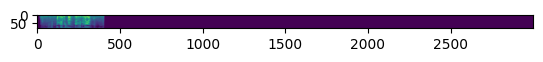

In [19]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots()
x = common_voice['train'][0]['input_features']
axs.imshow(x)

In [9]:
tokenizer.save_pretrained(f'tokenizers/{model_name}')

('tokenizers/openai/whisper-small/tokenizer_config.json',
 'tokenizers/openai/whisper-small/special_tokens_map.json',
 'tokenizers/openai/whisper-small/vocab.json',
 'tokenizers/openai/whisper-small/merges.txt',
 'tokenizers/openai/whisper-small/normalizer.json',
 'tokenizers/openai/whisper-small/added_tokens.json',
 'tokenizers/openai/whisper-small/tokenizer.json')